In [4]:
import os
import sys 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydicom

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk

train_path = '../data/train/'

In [5]:
train_dirs = os.listdir(train_path)

# Approach 1

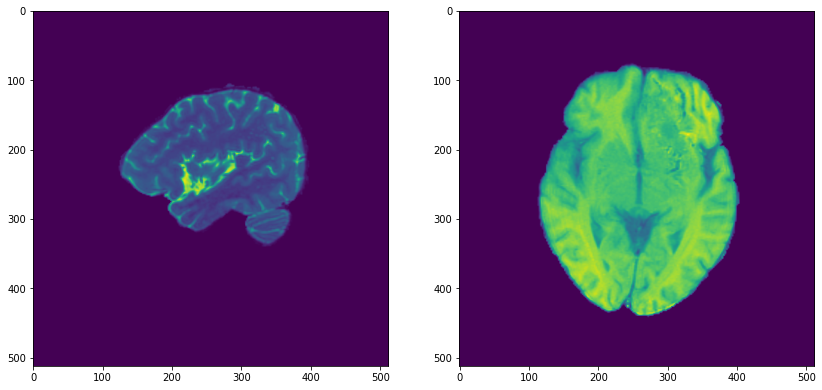

In [12]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(pydicom.dcmread(f'{train_path + train_dirs[0]}/T2w/Image-111.dcm').pixel_array)
plt.subplot(122)
plt.imshow(pydicom.dcmread(f'{train_path + train_dirs[0]}/T1w/Image-16.dcm').pixel_array)

In [13]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[2]}/T1w')
reader.SetFileNames(filenamesDICOM)
t1_sitk = reader.Execute()
t1_sitk

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000001F4E33F7E10> >

In [14]:
sitk.WriteImage(t1_sitk,'t1.nii')

In [15]:
t1_nib = nib.load('t1.nii')
t1_nib

In [16]:
t1_nib.shape

(512, 512, 33)

In [17]:
t1_nib_array = t1_nib.get_fdata() #the voxel array
t1_nib_array[:3]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [18]:
t1_nib_array.shape

(512, 512, 33)

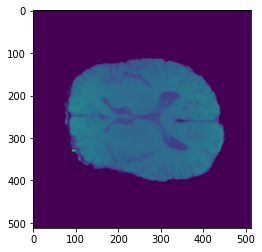

In [19]:
plt.imshow(t1_nib_array[:,:,t1_nib_array.shape[2]//2])

In [20]:
pydicom.dcmread(f'{train_path + train_dirs[0]}/T1w/Image-16.dcm').pixel_array.sum()

66028072

In [22]:
t1_nib_array.sum()

1104681229.0

In [23]:
np.set_printoptions(precision=4, suppress=True)
t1_nib.affine

array([[ -0.4668,   0.0431,   0.0549, 111.581 ],
       [ -0.0428,  -0.4663,   0.2379, 159.858 ],
       [  0.0072,   0.0217,   4.994 , -76.0355],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

In [24]:
t1_nib.affine[:3,:3] @ np.array([2,5,10]) + t1_nib.affine[:3,3]

array([111.4118, 159.8202, -25.9721])

In [25]:
t1_nib.affine @ np.array([2,5,10,1]) #(add 1 as a fourth coordinate)

array([111.4118, 159.8202, -25.9721,   1.    ])

In [26]:
filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[2]}/FLAIR')
reader.SetFileNames(filenamesDICOM)
flair_sitk = reader.Execute()
sitk.WriteImage(flair_sitk,'flair.nii')

flair_nib = nib.load('flair.nii')
flair_nib_array = flair_nib.get_fdata()

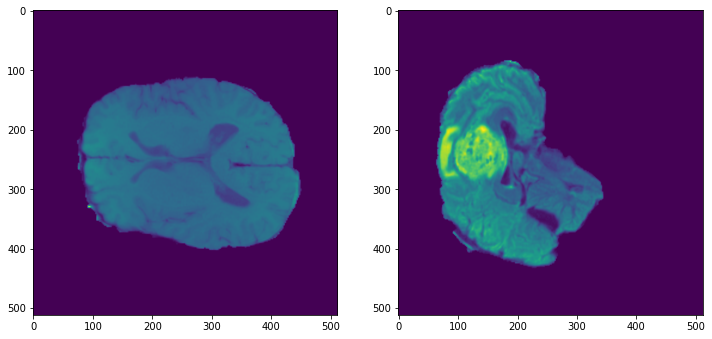

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(t1_nib_array[:,:,t1_nib_array.shape[2]//2])
plt.subplot(122)
plt.imshow(flair_nib_array[:,:,flair_nib_array.shape[2]//2])

In [30]:
t1_sitk.GetOrigin() # which is a translation column from the affine matrix, but negative

(-111.581, -159.858, -76.0355)

In [31]:
t1_sitk.GetSpacing() # which is how far away the voxel centers are from one another along each of the axes

(0.468800008296967, 0.468800008296967, 5.000000485821265)

In [32]:
t1_sitk.GetDirection() # a flatten cosine matrix which shows rotation of voxel space axes relative to scanner space

(0.9957045089297142,
 -0.09193492419824884,
 -0.010977276971051237,
 0.09131608598489906,
 0.994684261811466,
 -0.04758772683137683,
 0.015293898699659709,
 0.046380912207948884,
 0.9988067418902032)

In [33]:
cosine_from_dcm = pydicom.dcmread(filenamesDICOM[1]).ImageOrientationPatient
cosine_from_dcm

[-0.00396099, 0.99816103, 0.06048864, 0.06522313, 0.06061819, -0.9960278]

In [34]:
np.cross(cosine_from_dcm[:3], cosine_from_dcm[3:])

array([-0.9979,  0.    , -0.0653])

In [54]:
def resample(image, ref_image):

    resampler = sitk.ResampleImageFilter()
    
    resampler.SetReferenceImage(ref_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))

    resampler.SetOutputSpacing(ref_image.GetSpacing())

#     resampler.SetSize(ref_image.GetSize())

    resampler.SetOutputDirection(ref_image.GetDirection())

    resampler.SetOutputOrigin(ref_image.GetOrigin())

    resampler.SetDefaultPixelValue(image.GetPixelIDValue())

    resamped_image = resampler.Execute(image)
    
    return resamped_image


In [55]:
flair_resampled = resample(flair_sitk, t1_sitk)

In [56]:
t1_sitk_array = sitk.GetArrayFromImage(t1_sitk)
flair_resampled_array = sitk.GetArrayFromImage(flair_resampled)

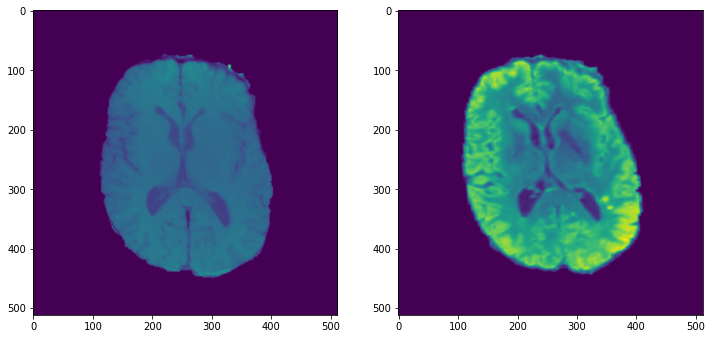

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(t1_sitk_array[t1_sitk_array.shape[0]//2,:,:])
plt.subplot(122)
plt.imshow(flair_resampled_array[flair_resampled_array.shape[0]//2,:,:])

In [59]:
print(t1_sitk_array.shape)
print(flair_resampled_array.shape)

(33, 512, 512)
(33, 512, 512)


In [52]:
t1_sitk_array.shape

AttributeError: 'numpy.ndarray' object has no attribute 'shape16'

In [42]:
t1_resampled = resample(t1_sitk,flair_sitk)

In [43]:
flair_sitk_array = sitk.GetArrayFromImage(flair_sitk)
t1_resampled_array = sitk.GetArrayFromImage(t1_resampled)

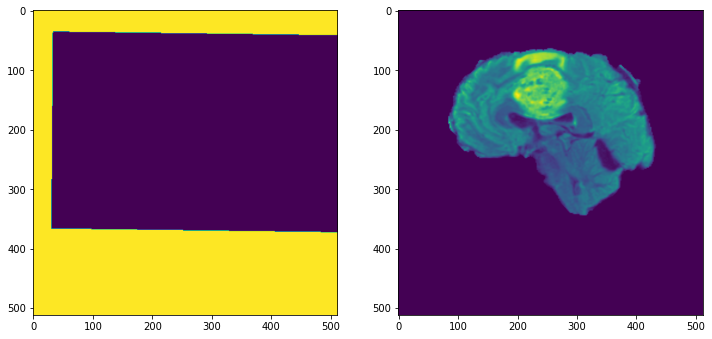

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(t1_resampled_array[16,:,:])
plt.subplot(122)
plt.imshow(flair_sitk_array[flair_sitk_array.shape[0]//2,:,:])

In [46]:
t1_resampled_array.shape

(129, 512, 512)

In [47]:
flair_sitk_array.shape

(129, 512, 512)

## Using NiLearn

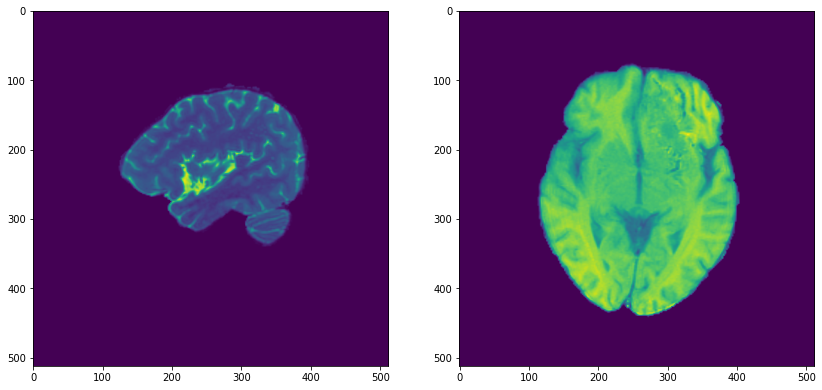

In [6]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(pydicom.dcmread(f'{train_path + train_dirs[0]}/T2w/Image-111.dcm').pixel_array)
plt.subplot(122)
plt.imshow(pydicom.dcmread(f'{train_path + train_dirs[0]}/T1w/Image-16.dcm').pixel_array)

In [7]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

In [8]:
filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[2]}/T1w')
reader.SetFileNames(filenamesDICOM)
t1_sitk = reader.Execute()

sitk.WriteImage(t1_sitk,'t1.nii')

In [9]:
t1_nib = nib.load('t1.nii')
t1_nib

In [10]:
t1_nib_array = t1_nib.get_fdata() #the voxel array
t1_nib_array[:3]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [11]:
t1_nib_array.shape

(512, 512, 33)

In [12]:
np.set_printoptions(precision=4, suppress=True)
t1_nib.affine

array([[ -0.4668,   0.0431,   0.0549, 111.581 ],
       [ -0.0428,  -0.4663,   0.2379, 159.858 ],
       [  0.0072,   0.0217,   4.994 , -76.0355],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

In [13]:
filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[2]}/FLAIR')
reader.SetFileNames(filenamesDICOM)
flair_sitk = reader.Execute()
sitk.WriteImage(flair_sitk,'flair.nii')

flair_nib = nib.load('flair.nii')
flair_nib_array = flair_nib.get_fdata()

In [14]:
print(t1_nib_array.shape)
print(flair_nib_array.shape)

(512, 512, 33)
(512, 512, 129)


In [15]:
from nilearn.image import resample_img

In [20]:
%%time 
flair_resampled = resample_img(flair_nib, target_affine=t1_nib.affine, target_shape=t1_nib.shape)
flair_resampled_array = flair_resampled.get_fdata()

C:\Users\91954\Documents\pytorch_env\lib\site-packages\nilearn\image\resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


Wall time: 7.81 s


In [21]:
print(flair_resampled_array.shape)

(512, 512, 33)


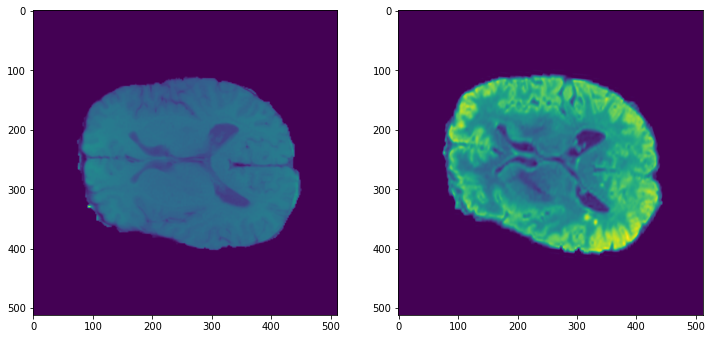

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(t1_nib_array[:,:,t1_nib_array.shape[2]//2])
plt.subplot(122)
plt.imshow(flair_resampled_array[:,:,flair_resampled_array.shape[2]//2])

In [23]:
def N4():
    print("N4 bias correction runs.")
    inputImage = sitk.ReadImage("06-t1c.nii.gz")
    # maskImage = sitk.ReadImage("06-t1c_mask.nii.gz")
    maskImage = sitk.OtsuThreshold(inputImage,0,1,200)
    sitk.WriteImage(maskImage, "06-t1c_mask3.nii.gz")

    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

    corrector = sitk.N4BiasFieldCorrectionImageFilter();

    output = corrector.Execute(inputImage,maskImage)
    sitk.WriteImage(output,"06-t1c_output3.nii.gz")
    print("Finished N4 Bias Field Correction.....")